In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None
%matplotlib inline
import matplotlib
#matplotlib.use('agg')
matplotlib.style.use('ggplot')
import pickle as pkl
from matplotlib import pyplot as plt
from collections import Counter
from functools import reduce

In [2]:
br_to_us=pd.read_excel("Book.xlsx")
br_to_us_dict=dict(zip(br_to_us.UK.tolist(),br_to_us.US.tolist()))
decades=[2000, 1990, 1980, 1970, 1960, 1950, 1940, 1930, 1920, 1900, 1910,
            1890, 1880, 1870, 1850, 1860, 1840, 1830, 1820, 1810, 1800]
old_decades=decades[1:]
l1=dict(zip([1,-1],['Positive','Negative']))
replacements={'modifier':br_to_us_dict,'head':br_to_us_dict,'Class':l1}


In [5]:
def tupleconverter(tup):
    dicter={}
    for word,decade in tup:
        #print(word,decade)
        if word in dicter:
            dicter[word].append(decade)
        else:
            dicter[word]=[]
            dicter[word].append(decade)
            
    #for word,decades in dicter.items():
        #print(word)
        #print(decades)
        #dicter[word]=Counter(decades)
        #print(dicter[word])
    return(dicter)


def decremover(dc):

    new_constituents=[]
    for constituent,decades in dc.items():
        if len(decades)==1:
            if 2000 in decades:
                new_constituents.append(constituent)
    return(new_constituents)




def magnituder(x):
    return(np.sqrt(np.sum(np.square(x))))

def new_compound_finder(df,decade=2000):
    new_compounds=[]
    for key,val in compound_decades.items():
        if len(val)==1 and decade in val:
            new_compounds.append(key)
    return new_compounds

def lemma_maker(x):
    #print(x,y)
    return lemmatizer.lemmatize(x)    

## Removing names using the NER Tagger 

In [4]:
compounds=pd.read_csv("/data/dharp/compounding/datasets/compounds.csv")
compounds.info()
compounds=compounds=compounds.groupby(['modifier','head','context','decade'])['count'].sum().to_frame()
compounds.reset_index(inplace=True)
compounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100381552 entries, 0 to 100381551
Data columns (total 5 columns):
modifier    object
head        object
context     object
decade      int64
count       int64
dtypes: int64(2), object(3)
memory usage: 3.7+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60075611 entries, 0 to 60075610
Data columns (total 5 columns):
modifier    object
head        object
context     object
decade      int64
count       int64
dtypes: int64(2), object(3)
memory usage: 2.2+ GB


In [ ]:
compounds['compound']=compounds['modifier'].str[:-2]+" "+compounds['head'].str[:-2]
compounds.set_index(['modifier','head','decade'],inplace=True)
compounds

In [28]:
compounds_lists=np.unique(compounds['modifier'].str[:-2]+" "+compounds['head'].str[:-2])
compounds_lists_ner=[compound.title() for compound in compounds_lists]
len(compounds_lists_ner)

1136387

In [29]:
with open("/data/dharp/compounding/datasets/total_compound_list.txt","w",encoding="utf-8") as f:
    for compound in compounds_lists_ner:
        
        f.write(compound+"\n")

In [7]:
compounds_tagged=pd.read_csv("/data/dharp/compounding/datasets/total_compound_list_ner.txt", delim_whitespace=True,header=None)
compounds_tagged.columns=['modifier','head']
compounds_tagged['modifier']=compounds_tagged['modifier'].str.lower()
compounds_tagged['modifier'],compounds_tagged['modifier_ner']=compounds_tagged['modifier'].str.split("/").str
compounds_tagged['modifier']=compounds_tagged['modifier']+"_n"
compounds_tagged['head']=compounds_tagged['head'].str.lower()
compounds_tagged['head'],compounds_tagged['head_ner']=compounds_tagged['head'].str.split("/").str
compounds_tagged['head']=compounds_tagged['head']+"_n"
compounds_tagged['NER']=None
compounds_tagged['NER'].loc[(compounds_tagged.modifier_ner=="person") & (compounds_tagged.head_ner=="person")]="person"
compounds_tagged['NER'].loc[(compounds_tagged.modifier_ner=="organization") & (compounds_tagged.head_ner=="organization")]="organization"
compounds_tagged['NER'].loc[(compounds_tagged.modifier_ner=="location") & (compounds_tagged.head_ner=="location")]="location"
proper_compounds=compounds_tagged[['modifier','head']].loc[compounds_tagged['NER'].isnull()].values
proper_compounds=[modifier+" "+head for modifier,head in proper_compounds]
len(proper_compounds)

828248

In [34]:
compounds_tagged_counts=compounds_tagged.NER.value_counts(dropna=False).to_frame()
compounds_tagged_counts['perc']=round((compounds_tagged_counts.NER/compounds_tagged_counts.NER.sum())*100,3)
compounds_tagged_counts

,NER,perc
NaN,828248,72.884
person,248825,21.896
organization,31308,2.755
location,28006,2.464


In [ ]:
compounds["compounds"]=compounds['modifier']+" "+compounds['head']
compounds=compounds.loc[compounds["compounds"].isin(proper_compounds)]
compounds=compounds.groupby(["compounds","decade"]).filter(lambda x: x['count'].sum() >= 15.)
compounds

In [83]:
heads_list=compounds.reset_index()['head'].unique()
display(len(heads_list))
modifiers_list=compounds.reset_index()['modifier'].unique()
len(modifiers_list)

53970

56286

In [55]:
compounds.drop(['index'],axis=1,inplace=True)
compounds.set_index(['modifier','head','decade'],inplace=True)
compounds.to_csv("/data/dharp/compounding/datasets/compounds_reduced.csv",sep="\t")

In [59]:
compound_counts=compounds.groupby(['modifier','head','decade'])['count'].sum().to_frame()
compound_counts.columns=['compound_count']
compound_decades=compound_counts.reset_index().groupby(['modifier','head'])['decade'].unique()
new_compound_list=new_compound_finder(compound_decades,2000)
print("There are "+str(len(new_compound_list))+" new compounds in the deacade 2000's")

There are 32180 new compounds in the deacade 2000's


In [84]:
heads=pd.read_csv("/data/dharp/compounding/datasets/heads.csv")
display(heads.shape)
total_head_count=heads['count'].sum()
heads=heads.groupby(['head','context','decade'])['count'].sum().to_frame()
heads.reset_index(inplace=True)
display(heads.shape)
heads=heads.loc[heads['head'].isin(heads_list)]
display(heads.shape)
heads_list=list(set(zip(heads["head"],heads["decade"])))
head_list=tupleconverter(heads_list)
new_heads=decremover(head_list)
print("There are "+str(len(new_heads))+" new heads in the deacade 2000's")
heads=heads.loc[~heads['head'].isin(new_heads)]
heads.set_index(['head','decade'],inplace=True)
heads

(70019978, 4)

(33226515, 4)

(31426926, 4)

There are 504 new heads in the deacade 2000's


context  count
head          decade                      
a_n           1800              a_a      4
              1810              a_a     20
              1820              a_a     10
              1830              a_a     14
              1840              a_a     14
              1850              a_a     34
              1860              a_a     52
              1870              a_a     14
              1880              a_a     23
              1890              a_a     30
              1900              a_a     65
              1910              a_a    225
              1920              a_a    201
              1930              a_a    263
              1940              a_a    563
              1950              a_a    929
              1960              a_a   1043
              1970              a_a   1039
              1980              a_a   1184
              1990              a_a   1679
              2000              a_a   1898
              1800              a_n     16
              1810              a_n     49
              1820              a_n     36
              1830              a_n     37
              1840              a_n     25
              1850              a_n     56
              1860              a_n     42
              1870              a_n     60
              1880              a_n    110
...                             ...    ...
zwingli_n     1940           work_n      4
              1950           work_n     19
              1960           work_n     35
              1970           work_n     17
              1980           work_n     52
              1990           work_n     49
              2000           work_n     60
              1900         zurich_n      6
              1910         zurich_n      1
              1950         zurich_n      1
              1960         zurich_n      5
              1970         zurich_n      8
              1980         zurich_n     21
              1990         zurich_n     44
              2000         zurich_n     41
zygmunt_n     1990         bauman_n     27
              2000         bauman_n     61
              1990           have_v     15
              2000           have_v     26
zygomycetes_n 1970         member_n      4
              1980         member_n     10
              1990         member_n     18
              2000         member_n     17
zygote_n      1990       cultured_a     67
              2000       cultured_a    117
              1990    development_n     42
              2000    development_n     77
              1980         genome_n     25
              1990         genome_n     15
              2000         genome_n     31

[31425759 rows x 2 columns]

In [91]:
with open("/data/dharp/compounding/datasets/new_heads.txt","w",encoding="utf-8") as f:
    for head in new_heads:
        
        f.write(head+"\n")

In [88]:
modifiers=pd.read_csv("/data/dharp/compounding/datasets/modifiers.csv")
display(modifiers.shape)
total_modifier_count=modifiers['count'].sum()
modifiers=modifiers.groupby(['modifier','context','decade'])['count'].sum().to_frame()
modifiers.reset_index(inplace=True)
display(modifiers.shape)
modifiers=modifiers.loc[modifiers['modifier'].isin(modifiers_list)]
display(modifiers.shape)
modifiers_list=list(set(zip(modifiers["modifier"],modifiers["decade"])))
modifiers_list=tupleconverter(modifiers_list)
new_modifiers=decremover(modifiers_list)
print("There are "+str(len(new_modifiers))+" new modifiers in the deacade 2000's")
modifiers=modifiers.loc[~modifiers['modifier'].isin(new_modifiers)]
modifiers.set_index(['modifier','decade'],inplace=True)
modifiers

(61829758, 4)

(29756100, 4)

(26743782, 4)

There are 808 new modifiers in the deacade 2000's


context  count
modifier       decade                    
a_n            1830            a_n      1
               1870            a_n      1
               1880            a_n      3
               1890            a_n      1
               1900            a_n      1
               1910            a_n      2
               1920            a_n     15
               1930            a_n     34
               1940            a_n     13
               1950            a_n     39
               1960            a_n    102
               1970            a_n    121
               1980            a_n    139
               1990            a_n    130
               2000            a_n    178
               1990    accession_n     20
               2000    accession_n     41
               1920      account_n      2
               1930      account_n      1
               1950      account_n      5
               1960      account_n      2
               1970      account_n      5
               1980      account_n      5
               1990      account_n     12
               2000      account_n     30
               1800          act_n      1
               1810          act_n      2
               1820          act_n      4
               1830          act_n      5
               1840          act_n      5
...                            ...    ...
zygote_n       1950     division_n      4
               1960     division_n      6
               1970     division_n      8
               1980     division_n      7
               1990     division_n      9
               2000     division_n     22
zygotene_n     1950      meiosis_n      4
               1960      meiosis_n     18
               1970      meiosis_n     22
               1980      meiosis_n     31
               1990      meiosis_n     19
               2000      meiosis_n     12
zylobalsamum_n 1890           be_v     18
               1900           be_v      2
               1910           be_v      1
               1920           be_v      5
               1930           be_v      1
               1960           be_v      2
               1970           be_v      1
               1990           be_v      3
               2000           be_v      9
               1890         call_v     18
               1900         call_v      2
               1910         call_v      1
               1920         call_v      5
               1930         call_v      1
               1960         call_v      2
               1970         call_v      1
               1990         call_v      3
               2000         call_v      9

[26742053 rows x 2 columns]

In [90]:
with open("/data/dharp/compounding/datasets/new_modifiers.txt","w",encoding="utf-8") as f:
    for modifier in new_modifiers:
        
        f.write(modifier+"\n")

In [94]:
compounds.reset_index(inplace=True)

In [105]:
compounds=compounds.loc[~(compounds.modifier.isin(new_modifiers) | (compounds['head'].isin(new_heads)))]
compound_counts=compounds.groupby(['modifier','head','decade'])['count'].sum().to_frame()
compound_counts.columns=['compound_count']
compound_decades=compound_counts.reset_index().groupby(['modifier','head'])['decade'].unique()
new_compound_list=new_compound_finder(compound_decades,2000)
print("There are "+str(len(new_compound_list))+" new compounds in the deacade 2000's")

There are 30759 new compounds in the deacade 2000's


In [107]:
with open("/data/dharp/compounding/datasets/novel_compounds.txt","w",encoding="utf-8") as f:
    for h,m in new_compound_list:
        
        f.write(h+" "+m+"\n")

In [108]:
head_counts=heads.groupby(['head','decade'])['count'].sum().to_frame()
head_counts.columns=['head_count']
head_counts

head_count
head          decade            
a_n           1800          1134
              1810          1747
              1820          2609
              1830          2964
              1840          3338
              1850          5276
              1860          4797
              1870          7284
              1880         10146
              1890         14328
              1900         19688
              1910         22121
              1920         33978
              1930         42200
              1940         61759
              1950        101951
              1960        165115
              1970        230289
              1980        320321
              1990        459848
              2000        588664
aa_n          1800            22
              1810            44
              1820            60
              1830            27
              1840            23
              1850           136
              1860            50
              1870            59
              1880            64
...                          ...
zvi_n         1960            98
              1970           112
              1980           179
              1990           149
              2000           664
zwingli_n     1850             4
              1860             6
              1870             7
              1880            21
              1890            31
              1900            70
              1910           103
              1920            89
              1930            25
              1940            56
              1950           151
              1960           226
              1970           190
              1980           465
              1990           832
              2000          1255
zygmunt_n     1990            42
              2000            87
zygomycetes_n 1970             4
              1980            10
              1990            18
              2000            17
zygote_n      1980            25
              1990           124
              2000           225

[638939 rows x 1 columns]

In [109]:
head_counts.describe()

,head_count
count,638939.000
mean,5260.676
std,111099.920
min,1.000
25%,11.000
50%,52.000
75%,315.000
max,42243992.000


In [110]:
modifer_counts=modifiers.groupby(['modifier','decade'])['count'].sum().to_frame()
modifer_counts.columns=['mod_count']
modifer_counts

mod_count
modifier        decade           
a_n             1800          160
                1810          151
                1820          109
                1830          183
                1840          377
                1850          613
                1860          777
                1870         1038
                1880         2150
                1890         3247
                1900         5010
                1910         6480
                1920         4870
                1930         5833
                1940         3743
                1950         6414
                1960        10122
                1970        17420
                1980        19908
                1990        28593
                2000        43129
aa_n            1800           10
                1810           49
                1820           37
                1830           16
                1850            4
                1860            8
                1870           21
                1880           11
                1900           22
...                           ...
zwitterion_n    2000            2
zygapophyseal_n 1960            3
                1970            4
                1980           38
                1990          259
                2000          513
zygote_n        1920            5
                1930            9
                1940            2
                1950           12
                1960           10
                1970           19
                1980           14
                1990           10
                2000           25
zygotene_n      1950            4
                1960           18
                1970           22
                1980           31
                1990           19
                2000           12
zylobalsamum_n  1890           36
                1900            4
                1910            2
                1920           10
                1930            2
                1960            4
                1970            2
                1990            6
                2000           18

[566854 rows x 1 columns]

In [111]:
modifer_counts.describe()

,mod_count
count,566854.000
mean,5315.294
std,118039.703
min,1.000
25%,12.000
50%,58.000
75%,359.000
max,39202743.000


## Saving the datasets

In [112]:
compounds.to_csv("/data/dharp/compounding/datasets/compounds_reduced.csv",sep="\t")

In [113]:
modifiers.to_csv("/data/dharp/compounding/datasets/modifiers_reduced.csv",sep="\t")

In [114]:
heads.to_csv("/data/dharp/compounding/datasets/heads_reduced.csv",sep="\t")

# Feature Extractions (for collocations)

In [5]:
compound_decade_counts=compounds.groupby(['decade'])['count'].sum().to_frame()
compound_decade_counts.columns=['N']
compound_decade_counts

NameError: name 'compounds' is not defined

In [30]:
XY=compounds.groupby(['modifier','head','decade'])['count'].sum().to_frame()
XY.columns=['a']
X_star=compounds.groupby(['modifier','decade'])['count'].sum().to_frame()
X_star.columns=['x_star']
Y_star=compounds.groupby(['head','decade'])['count'].sum().to_frame()
Y_star.columns=['star_y']
merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier','decade'])
information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head','decade'])
information_feat['b']=information_feat['x_star']-information_feat['a']
information_feat['c']=information_feat['star_y']-information_feat['a']
information_feat=pd.merge(information_feat,compound_decade_counts.reset_index(),on=['decade'])
information_feat['d']=information_feat['N']-(information_feat['a']+information_feat['b']+information_feat['c'])
information_feat['x_bar_star']=information_feat['N']-information_feat['x_star']
information_feat['star_y_bar']=information_feat['N']-information_feat['star_y']
#information_feat['LR']=-2*np.sum(information_feat['a']*np.log2((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y'])))
information_feat.set_index(['modifier','head','decade'],inplace=True)
information_feat.replace(0,0.001,inplace=True)
information_feat['log_ratio']=2*(information_feat['a']*np.log((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y']))+\
information_feat['b']*np.log((information_feat['b']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y_bar']))+\
information_feat['c']*np.log((information_feat['c']*information_feat['N'])/(information_feat['x_bar_star']*information_feat['star_y']))+\
information_feat['d']*np.log((information_feat['d']*information_feat['N'])/(information_feat['x_bar_star']*information_feat['star_y_bar'])))
information_feat['ppmi']=np.log2((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y']))
information_feat['local_mi']=information_feat['a']*information_feat['ppmi']
information_feat.ppmi.loc[information_feat.ppmi<=0]=0
information_feat.drop(['a','x_star','star_y','b','c','d','N','d','x_bar_star','star_y_bar'],axis=1,inplace=True)
information_feat

,,,log_ratio,ppmi,local_mi
modifier,head,decade,,,
a_n,bell_n,1970,171.744,9.612,144.174
alarm_n,bell_n,1970,788.974,8.941,670.604
brass_n,bell_n,1970,139.774,8.124,121.859
canterbury_n,bell_n,1970,134.638,9.456,113.468
chapel_n,bell_n,1970,342.395,10.429,281.571
charles_n,bell_n,1970,60.845,4.287,64.298
church_n,bell_n,1970,5589.644,9.206,4584.580
courthouse_n,bell_n,1970,159.902,12.813,115.319
door_n,bell_n,1970,434.741,8.839,371.247


In [31]:
information_feat.describe()

,log_ratio,ppmi,local_mi
count,466873.000,466873.000,466873.000
mean,2376.273,7.444,1844.506
std,33682.170,3.986,21850.493
min,0.000,0.000,-6544.587
25%,128.870,4.597,114.613
50%,331.313,7.380,279.383
75%,961.172,10.198,799.335
max,10560697.662,22.037,6470296.738


In [32]:
information_feat.loc[information_feat['ppmi']<=0].sort_values(by=['ppmi'],ascending=True)

,,,log_ratio,ppmi,local_mi
modifier,head,decade,,,
banking_n,group_n,1970,10.348,0.000,-11.802
world_n,energy_n,2000,131.383,0.000,-116.995
district_n,a_n,2000,60.128,0.000,-67.579
language_n,a_n,2000,0.734,0.000,-5.071
state_n,a_n,2000,478.019,0.000,-73.605
time_n,a_n,2000,162.213,0.000,-63.110
blood_n,b_n,2000,487.816,0.000,-288.295
district_n,b_n,2000,101.965,0.000,-87.077
input_n,b_n,2000,0.940,0.000,-3.980


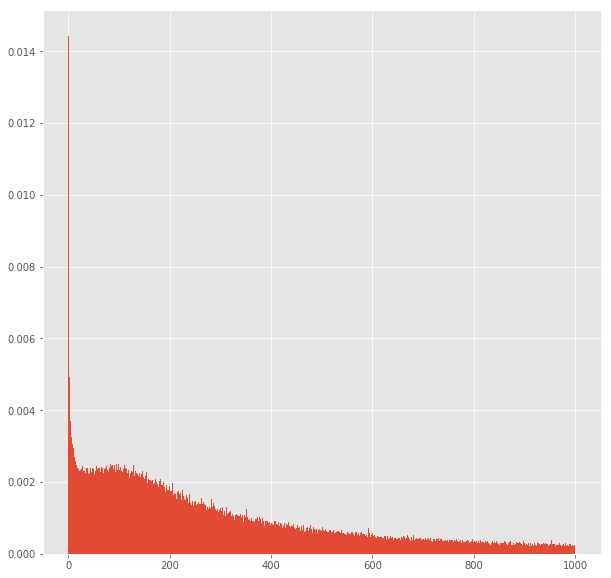

In [33]:
ax = information_feat.log_ratio.hist(figsize=(10, 10),bins=1000,range=(0,1000),normed=True)
#ax.set_ylim(0,750)

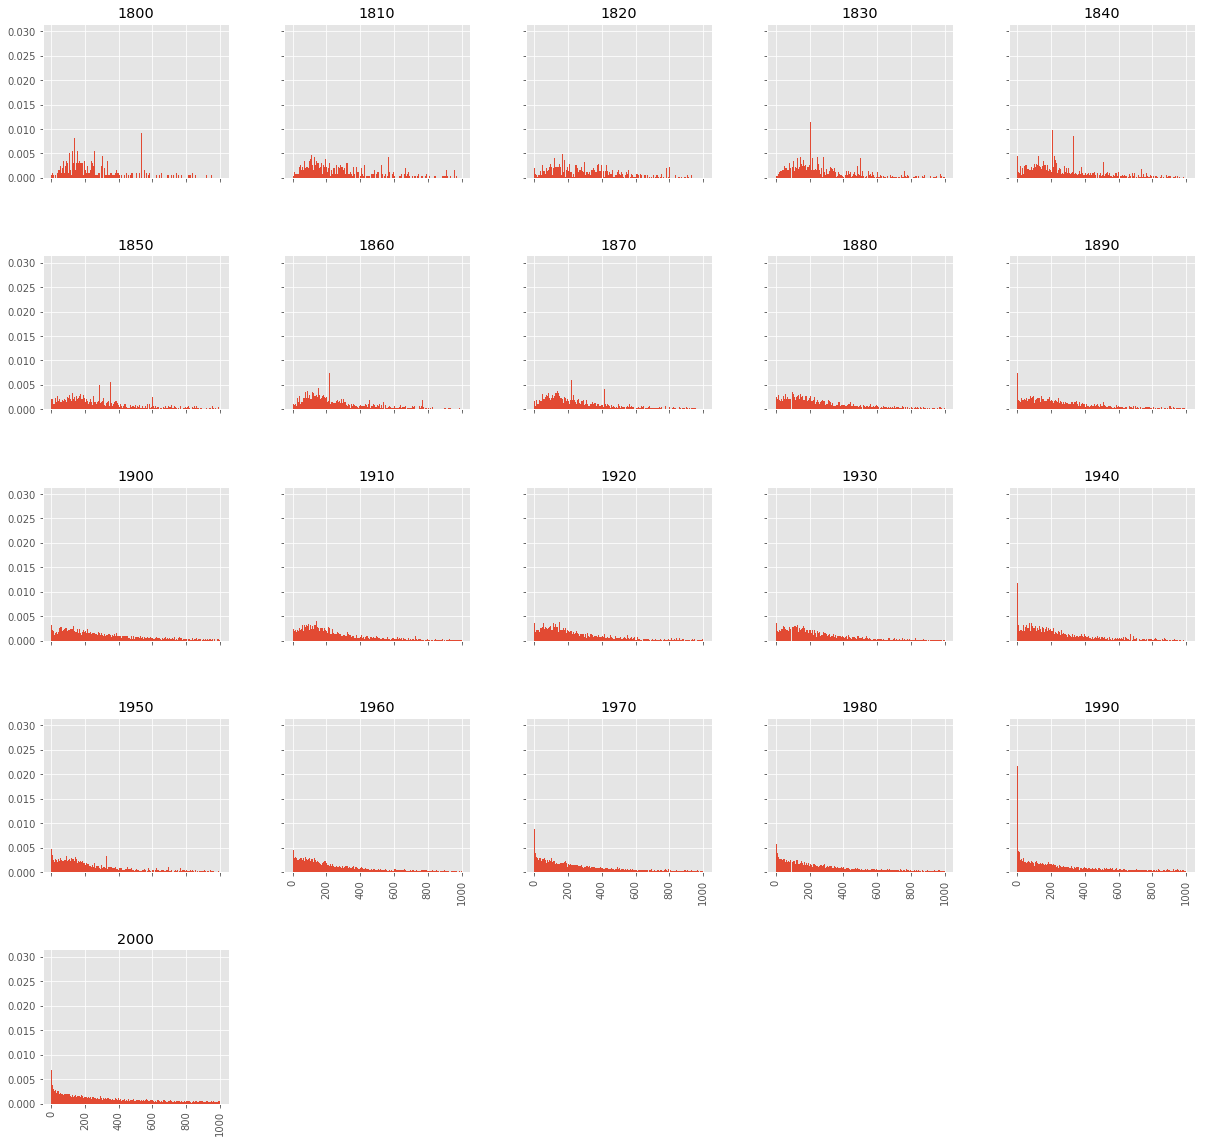

In [34]:
_=information_feat.hist(by="decade",column ='log_ratio', figsize=(20, 20),bins=1000,sharex=True,sharey=True,normed=True,range=(0,1000))

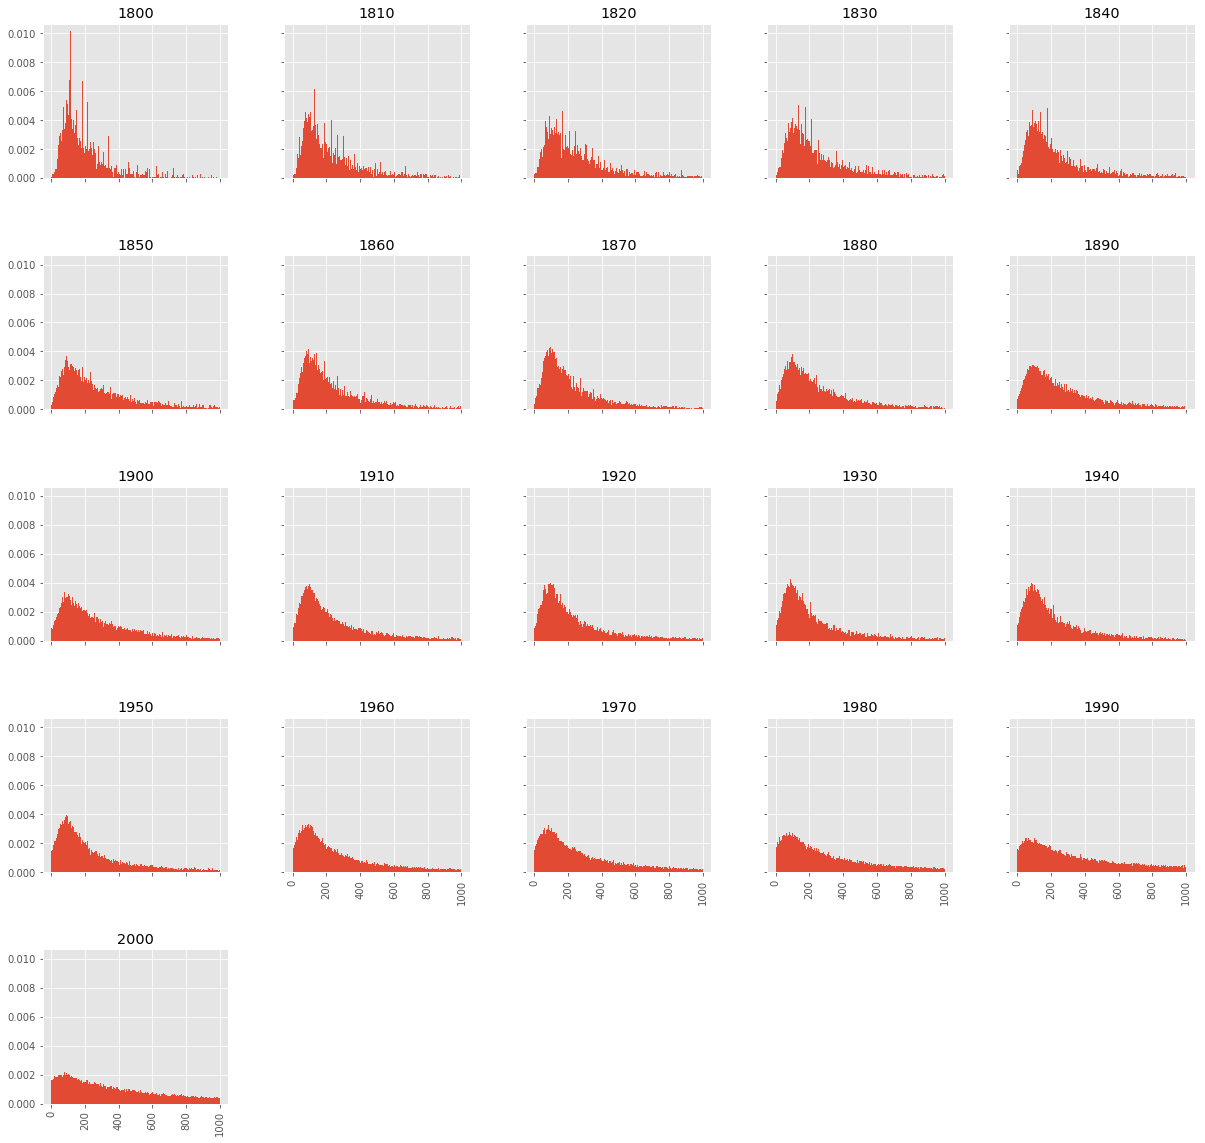

In [35]:
#plt.subplot(7, 3)
_=information_feat.hist(by="decade",column ='local_mi', figsize=(20, 20),bins=200,sharex=True,sharey=True,normed=True,range=[0,1000])

## Selection of compounds for Compositionality ratings

# Cosine Similarity Calculation

## 1. Conversion to PPMI values ( association between word and contexts)

### Modifiers

In [36]:
modifier_decade_counts=modifiers.groupby(['decade'])['count'].sum().to_frame()
modifier_decade_counts.columns=['N']
modifier_decade_counts

,N
decade,
1800,95741
1810,164585
1820,248590
1830,359661
1840,425872
1850,781083
1860,672653
1870,797832
1880,1232780


In [37]:
new_modifiers=modifiers.groupby(['modifier','context','decade'])['count'].sum().to_frame()
new_modifiers.columns=['a']
mod_star=modifiers.groupby(['modifier','decade'])['count'].sum().to_frame()
mod_star.columns=['mod_star']
context_star=modifiers.groupby(['context','decade'])['count'].sum().to_frame()
context_star.columns=['context_star']
merge1=pd.merge(new_modifiers.reset_index(),mod_star.reset_index(),on=['modifier','decade'])
new_modifiers=pd.merge(merge1,context_star.reset_index(),on=['context','decade'])
new_modifiers=pd.merge(new_modifiers,modifier_decade_counts.reset_index(),on=["decade"])
new_modifiers['modifier_ppmi']=np.log2((new_modifiers['a']*new_modifiers['N'])/(new_modifiers['mod_star']*new_modifiers['context_star']**0.75))
new_modifiers.set_index(['modifier','decade'],inplace=True)
new_modifiers.drop(['a','mod_star','context_star','N'],axis=1,inplace=True)
new_modifiers.modifier_ppmi.loc[new_modifiers.modifier_ppmi<=0]=0
new_modifiers

,,context,modifier_ppmi
modifier,decade,,
a_n,1970,almanac_n,13.870
almanac_n,1970,almanac_n,19.377
county_n,1970,almanac_n,9.500
a_n,1970,be_v,3.977
aaron_n,1970,be_v,4.960
ab_n,1970,be_v,5.062
aba_n,1970,be_v,2.966
ababa_n,1970,be_v,6.025
abatement_n,1970,be_v,6.184


In [38]:
new_modifiers.modifier_ppmi.describe()

count   2278776.000
mean          7.241
std           3.653
min           0.000
25%           4.567
50%           6.858
75%           9.724
max          22.161
Name: modifier_ppmi, dtype: float64

### Heads

In [39]:
head_decade_counts=modifiers.groupby(['decade'])['count'].sum().to_frame()
head_decade_counts.columns=['N']
head_decade_counts

,N
decade,
1800,95741
1810,164585
1820,248590
1830,359661
1840,425872
1850,781083
1860,672653
1870,797832
1880,1232780


In [40]:
new_heads=heads.groupby(['head','context','decade'])['count'].sum().to_frame()
new_heads.columns=['a']
head_star=heads.groupby(['head','decade'])['count'].sum().to_frame()
head_star.columns=['head_star']
context_star=heads.groupby(['context','decade'])['count'].sum().to_frame()
context_star.columns=['context_star']
merge1=pd.merge(new_heads.reset_index(),head_star.reset_index(),on=['head','decade'])
new_heads=pd.merge(merge1,context_star.reset_index(),on=['context','decade'])
new_heads=pd.merge(new_heads,head_decade_counts.reset_index(),on=["decade"])
new_heads['head_ppmi']=np.log2((new_heads['a']*new_heads['N'])/(new_heads['head_star']*new_heads['context_star']**0.75))
new_heads.set_index(['head','decade'],inplace=True)
new_heads.drop(['a','head_star','context_star','N'],axis=1,inplace=True)
new_heads.head_ppmi.loc[new_heads.head_ppmi<=0]=0
new_heads

,,context,head_ppmi
head,decade,,
a_n,1950,abridge_v,8.320
congress_n,1950,abridge_v,5.321
freedom_n,1950,abridge_v,10.486
state_n,1950,abridge_v,4.352
a_n,1950,accredited_a,11.849
association_n,1950,accredited_a,5.123
college_n,1950,accredited_a,11.175
service_n,1950,accredited_a,2.729
a_n,1950,acquire_v,6.196


In [41]:
new_heads.head_ppmi.describe()

count   2725974.000
mean          7.109
std           3.631
min           0.000
25%           4.457
50%           6.737
75%           9.550
max          21.988
Name: head_ppmi, dtype: float64

## Compounds

In [42]:
new_compounds=compounds.groupby(['modifier','head','context','decade'])['count'].sum().to_frame()
new_compounds.columns=['a']
compound_star=compounds.groupby(['modifier','head','decade'])['count'].sum().to_frame()
compound_star.columns=['compound_star']
context_star=compounds.groupby(['context','decade'])['count'].sum().to_frame()
context_star.columns=['context_star']
new_compounds=pd.merge(new_compounds.reset_index(),compound_star.reset_index(),on=['modifier','head','decade'])
new_compounds=pd.merge(new_compounds,context_star.reset_index(),on=['context','decade'])
new_compounds=pd.merge(new_compounds,compound_decade_counts.reset_index(),on=["decade"])
new_compounds['compound_ppmi']=np.log2((new_compounds['a']*new_compounds['N'])/(new_compounds['compound_star']*new_compounds['context_star']**0.75))
new_compounds.set_index(['modifier','head','decade'],inplace=True)
new_compounds.drop(['a','compound_star','context_star','N'],axis=1,inplace=True)
new_compounds.compound_ppmi.loc[new_compounds.compound_ppmi<=0]=0
new_compounds

context  compound_ppmi
modifier      head           decade                                 
a_n           bell_n         1970     international_a         12.939
air_n         navigation_n   1970     international_a         12.617
              service_n      1970     international_a         11.588
              transport_n    1970     international_a          9.820
arbitration_n agreement_n    1970     international_a          7.463
arm_n         trade_n        1970     international_a         12.939
art_n         education_n    1970     international_a          8.641
banking_n     system_n       1970     international_a          5.948
black_n       hill_n         1970     international_a         10.354
book_n        search_n       1970     international_a         12.939
bretton_n     wood_n         1970     international_a         12.246
business_n    practice_n     1970     international_a         10.034
capital_n     asset_n        1970     international_a          8.725
              flow_n         1970     international_a         11.285
              market_n       1970     international_a          9.653
              mobility_n     1970     international_a          9.479
              movement_n     1970     international_a         10.842
class_n       movement_n     1970     international_a         11.105
cold_n        war_n          1970     international_a          4.807
commerce_n    commission_n   1970     international_a          3.214
commodity_n   agreement_n    1970     international_a         12.939
control_n     commission_n   1970     international_a         10.125
credit_n      card_n         1970     international_a          6.111
crisis_n      group_n        1970     international_a         12.939
development_n agency_n       1970     international_a          8.281
dispute_n     settlement_n   1970     international_a         10.716
distress_n    radio_n        1970     international_a         12.939
driving_n     license_n      1970     international_a         12.939
              permit_n       1970     international_a         12.939
european_n    advertising_n  1970     international_a         12.939
...                                               ...            ...
will_n        shakspeare_n   1820               sad_a         14.619
william_n     ashton_n       1820            height_n         11.534
                             1820              pace_v         11.784
              earl_n         1820       information_n         12.869
              johnson_n      1820            knight_v         13.369
              jones_n        1820            repute_v         10.760
              stanley_n      1820          restrain_v         12.477
              temple_n       1820           mortify_v          8.836
              young_n        1820          painting_n         12.475
woman_n       eve_n          1820            speech_n         14.930
              report_n       1820      incomparable_a         14.013
              seeker_n       1820           forward_a         12.475
wonder_n      rise_n         1820              step_n         13.524
wood_n        fire_n         1820             blaze_v         14.180
woodland_n    flower_n       1820              blue_a         14.377
word_n        circumstance_n 1820    characteristic_a         14.930
              foreign_n      1820         purposely_r         13.524
              glass_n        1820            bottle_n         13.524
              idea_n         1820           meaning_n         10.517
              linen_n        1820             imply_v         14.377
              lion_n         1820        distinctly_r         12.680
              probation_n    1820        distinctly_r         12.680
              nation_n       1820           instead_r         14.930
work_n        faith_n        1820           perfect_a         13.869
world_n       instruction_n  1820              oral_a         12.183
              war_n          1820          u

In [43]:
new_compounds.compound_ppmi.describe()

count   3179099.000
mean          8.850
std           3.904
min           0.000
25%           5.864
50%           8.394
75%          11.679
max          22.433
Name: compound_ppmi, dtype: float64

## 2. Similarity Calculation

In [44]:
modifier_denom=new_modifiers.groupby(['modifier',"decade"])['modifier_ppmi'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
modifier_denom.columns=['modifier_denom']
modifier_denom

modifier_denom
modifier     decade                
a_n          1800            25.355
             1810            28.475
             1850            21.009
             1860            20.536
             1890            32.060
             1900            34.575
             1910            32.755
             1920            26.686
             1960            41.426
             1970            56.358
             1980            57.717
             1990            67.871
             2000            67.976
aa_n         1940            25.567
             1950            24.270
             1960            24.967
             1970            26.044
             1980            26.859
             1990            27.067
             2000            27.319
aaa_n        1970            23.962
             1980            24.202
aaron_n      1810            16.301
             1830            14.410
             1840            19.597
             1850            28.113
             1860            28.325
             1870            34.036
             1880            31.923
             1890            36.686
...                             ...
zoning_n     1930            25.949
             1940            25.396
             1950            30.745
             1960            38.422
             1970            46.533
             1980            54.217
             1990            62.032
             2000            58.270
zoological_n 1890            19.877
             1900            21.079
             1910            20.448
             1920            20.486
             1930            20.339
             1940            21.013
             1950            21.706
             1960            22.278
             1970            22.649
             1980            23.207
             1990            23.830
             2000            24.177
zoom_n       1960            19.694
             1970            19.733
             1980            19.700
             1990            20.289
             2000            20.721
zurich_n     1840            21.209
             1860            21.916
             1870            22.609
             1960            28.823
             1970            19.999

[83796 rows x 1 columns]

In [45]:
head_denom=new_heads.groupby(['head',"decade"])['head_ppmi'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
head_denom.columns=['head_denom']
head_denom

head_denom
head      decade            
a_n       1800        26.670
          1810        33.438
          1830        47.050
          1840        46.165
          1850        53.130
          1860        50.811
          1870        48.430
          1880        62.828
          1890        60.718
          1900        70.849
          1910        66.244
          1920        48.405
          1930        58.200
          1940        61.478
          1950        71.549
          1960        83.341
          1970        86.866
          1980        92.601
          1990        96.414
          2000       100.251
aa_n      1980        30.531
          1990        31.606
          2000        32.147
aaron_n   1970        37.525
          1980        38.211
          1990        38.194
          2000        38.146
ab_n      1800        26.391
          1810        26.899
          1820        28.880
...                      ...
zion_n    1960        34.835
          1970        36.815
          1980        36.672
          1990        40.424
          2000        40.938
zionist_n 1970        20.669
          1980        21.095
          1990        21.550
zip_n     1960        26.930
          1970        27.400
          1980        33.212
          1990        34.410
          2000        27.733
zone_n    1830        21.289
          1840        21.772
          1850        22.906
          1860        22.847
          1870        23.164
          1890        27.364
          1900        31.721
          1910        34.174
          1920        35.947
          1930        43.164
          1940        46.422
          1950        55.130
          1960        62.415
          1970        73.664
          1980        80.052
          1990        92.551
          2000        89.525

[97925 rows x 1 columns]

In [46]:
compound_denom=new_compounds.groupby(['modifier','head',"decade"])['compound_ppmi'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
compound_denom.columns=['compound_denom']
compound_denom

compound_denom
modifier     head         decade                
a_n          bell_n       1970            27.098
                          1980            25.584
                          1990            25.284
             c_n          1800            15.615
                          1810            17.512
                          1850            17.561
                          1860            17.289
                          1870            17.738
                          1910            19.530
                          2000            20.839
             cassell_n    1990            32.066
                          2000            33.008
             chorus_n     1970            28.980
                          1980            27.946
                          1990            27.801
                          2000            28.074
             colonial_n   1900            20.916
                          2000            20.173
             man_n        1890            26.434
                          1900            26.294
                          1910            25.982
                          1920            25.194
                          2000            28.852
             publisher_n  1990            25.827
                          2000            24.804
             sand_n       1980            29.414
                          1990            28.354
                          2000            27.316
             series_n     1990            23.766
                          2000            23.969
...                                          ...
zoological_n park_n       1960            15.719
                          1970            16.143
                          1980            16.216
                          1990            16.956
                          2000            17.626
             society_n    1890            15.613
                          1900            15.660
                          1910            14.977
                          1920            14.783
                          1930            14.434
                          1940            15.069
                          1950            15.615
                          1960            15.983
                          1970            16.446
                          1980            17.148
                          1990            17.975
                          2000            17.884
zoom_n       lens_n       1960            15.802
                          1970            15.930
                          1980            16.007
                          1990            16.491
                          2000            16.748
zurich_n     agreement_n  1960            19.743
                          1970            20.029
             government_n 1840            21.520
                          1860            22.303
                          1870            23.129
                          1900            24.930
                          1910            25.395
                          1960            27.655

[466873 rows x 1 columns]

### Similarity between Modifier and Compound

In [47]:
compound_modifier_sim=pd.merge(new_compounds.reset_index(),new_modifiers.reset_index(),on=["modifier","context","decade"])
#merge2=pd.merge(merge1,compound_denom.reset_index(),on=["modifier","head","decade"])
#compound_modifier_sim=pd.merge(merge2,modifier_denom.reset_index(),on=["modifier","decade"])
#compound_modifier_sim['sim_with_head']=
compound_modifier_sim['numerator']=compound_modifier_sim['compound_ppmi']*compound_modifier_sim['modifier_ppmi']
compound_modifier_sim=compound_modifier_sim.groupby(['modifier','head','decade'])['numerator'].sum().to_frame()
compound_modifier_sim=pd.merge(compound_modifier_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head","decade"])
compound_modifier_sim=pd.merge(compound_modifier_sim,modifier_denom.reset_index(),on=['modifier','decade'])
compound_modifier_sim['sim_with_modifier']=compound_modifier_sim['numerator']/(compound_modifier_sim['compound_denom']*compound_modifier_sim['modifier_denom'])
compound_modifier_sim.set_index(['modifier','head','decade'],inplace=True)
compound_modifier_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)
compound_modifier_sim

modifier_denom  sim_with_modifier
modifier     head         decade                                   
a_n          bell_n       1970            56.358              0.353
             chorus_n     1970            56.358              0.383
             star_n       1970            56.358              0.281
             streetcar_n  1970            56.358              0.498
             bell_n       1980            57.717              0.378
             chorus_n     1980            57.717              0.384
             sand_n       1980            57.717              0.385
             star_n       1980            57.717              0.263
             streetcar_n  1980            57.717              0.463
             bell_n       1990            67.871              0.304
             cassell_n    1990            67.871              0.349
             chorus_n     1990            67.871              0.294
             publisher_n  1990            67.871              0.274
             sand_n       1990            67.871              0.321
             series_n     1990            67.871              0.267
             star_n       1990            67.871              0.190
             streetcar_n  1990            67.871              0.331
             y_n          1990            67.871              0.170
             c_n          1800            25.355              0.599
                          1810            28.475              0.588
                          1850            21.009              0.814
                          1860            20.536              0.821
                          1910            32.755              0.490
             man_n        1910            32.755              0.731
             c_n          2000            67.976              0.126
             cassell_n    2000            67.976              0.269
             chorus_n     2000            67.976              0.293
             colonial_n   2000            67.976              0.123
             man_n        2000            67.976              0.215
             publisher_n  2000            67.976              0.275
...                                          ...                ...
zoological_n park_n       1920            20.486              0.675
             society_n    1920            20.486              0.669
             park_n       1930            20.339              0.669
             society_n    1930            20.339              0.667
             park_n       1940            21.013              0.672
             society_n    1940            21.013              0.674
             park_n       1950            21.706              0.683
             society_n    1950            21.706              0.684
             park_n       1960            22.278              0.682
             society_n    1960            22.278              0.683
             park_n       1970            22.649              0.691
             society_n    1970            22.649              0.694
             park_n       1980            23.207              0.654
             society_n    1980            23.207              0.709
             park_n       1990            23.830              0.667
             society_n    1990            23.830              0.725
             park_n       2000            24.177              0.707
             society_n    2000            24.177              0.708
                          1890            19.877              0.716
zoom_n       lens_n       1960            19.694              0.569
                          1970            19.733              0.582
                          1980            19.700              0.576
                          1990            20.289              0.594
                          2000            20.721              0.590
zurich_n     agreement_n  1960            28.823              0.401
             government_n 1960            28.823              0.597
             agreement

In [48]:
compound_modifier_sim.sim_with_modifier.describe()

count   461272.000
mean         0.253
std          0.202
min          0.000
25%          0.105
50%          0.184
75%          0.338
max          1.000
Name: sim_with_modifier, dtype: float64

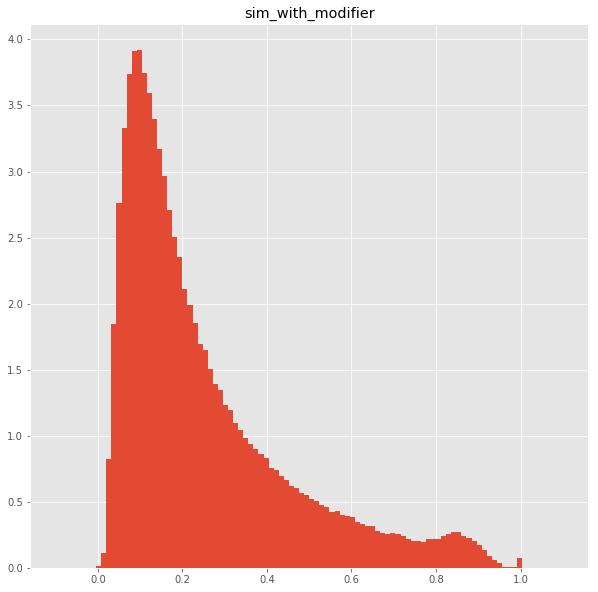

In [49]:
_=compound_modifier_sim.hist(column ='sim_with_modifier', figsize=(10, 10),bins=100,sharex=True,sharey=True,normed=True,range=(-0.1,1.1))

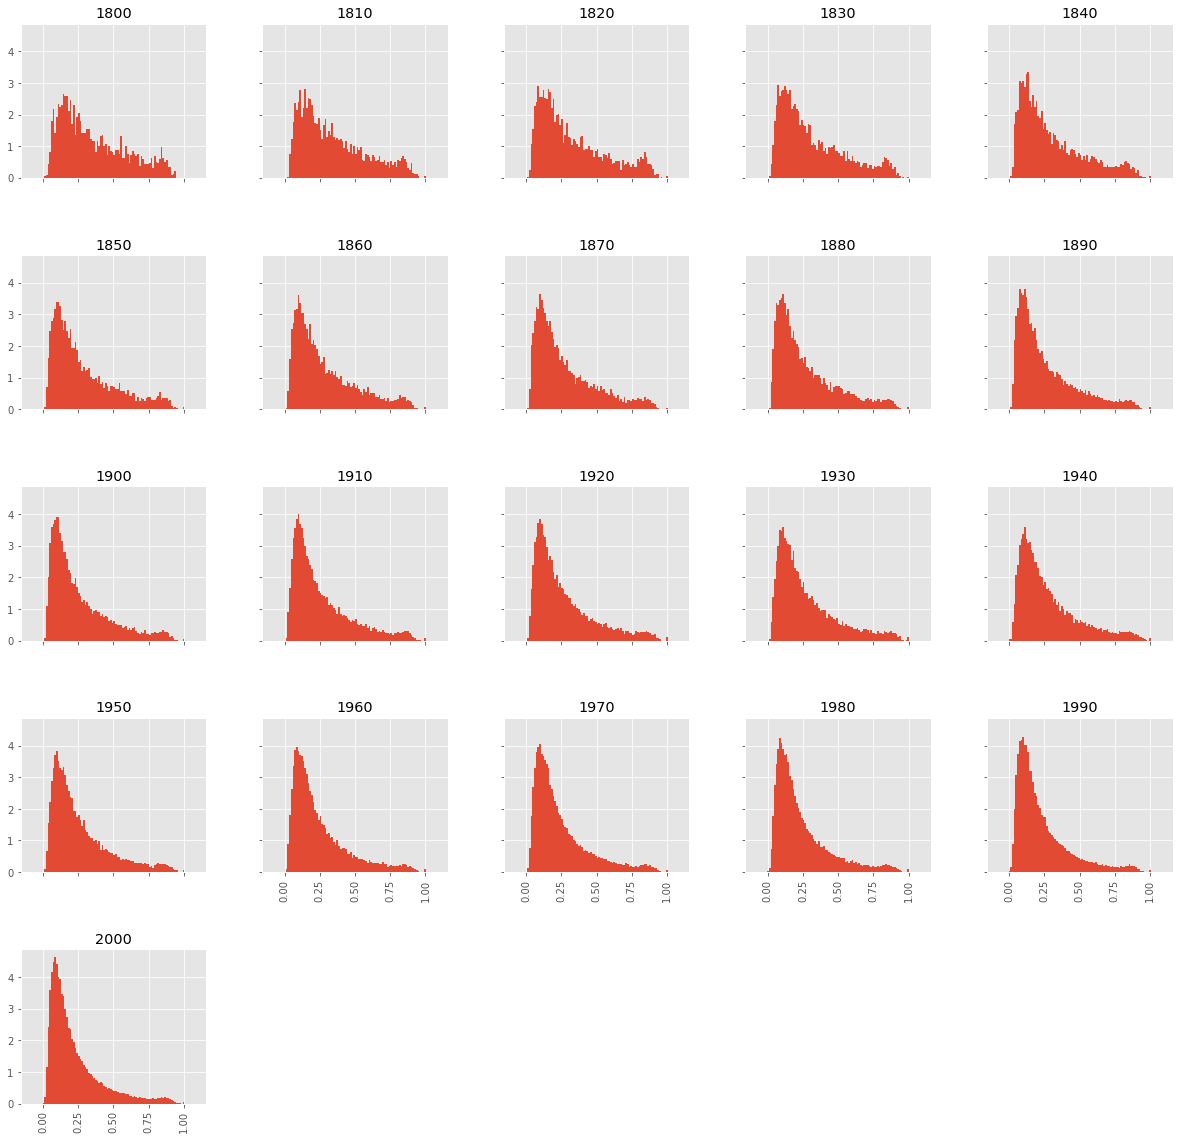

In [50]:
_=compound_modifier_sim.hist(by= 'decade',column ='sim_with_modifier', figsize=(20, 20),bins=100,sharex=True,sharey=True,normed=True,range=(-0.1,1.1))

### Similarity between Head and Compound

In [51]:
compound_head_sim=pd.merge(new_compounds.reset_index(),new_heads.reset_index(),on=["head","context","decade"])

compound_head_sim['numerator']=compound_head_sim['compound_ppmi']*compound_head_sim['head_ppmi']
compound_head_sim=compound_head_sim.groupby(['modifier','head','decade'])['numerator'].sum().to_frame()
compound_head_sim=pd.merge(compound_head_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head","decade"])
compound_head_sim=pd.merge(compound_head_sim,head_denom.reset_index(),on=['head','decade'])
compound_head_sim['sim_with_head']=compound_head_sim['numerator']/(compound_head_sim['compound_denom']*compound_head_sim['head_denom'])
compound_head_sim.set_index(['modifier','head','decade'],inplace=True)
compound_head_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)
compound_head_sim

,,,head_denom,sim_with_head
modifier,head,decade,,
a_n,bell_n,1970,89.586,0.108
alarm_n,bell_n,1970,89.586,0.267
brass_n,bell_n,1970,89.586,0.206
canterbury_n,bell_n,1970,89.586,0.116
chapel_n,bell_n,1970,89.586,0.184
charles_n,bell_n,1970,89.586,0.099
church_n,bell_n,1970,89.586,0.440
courthouse_n,bell_n,1970,89.586,0.134
door_n,bell_n,1970,89.586,0.203


In [52]:
compound_head_sim.sim_with_head.describe()

count   461773.000
mean         0.309
std          0.230
min          0.000
25%          0.132
50%          0.232
75%          0.426
max          1.000
Name: sim_with_head, dtype: float64

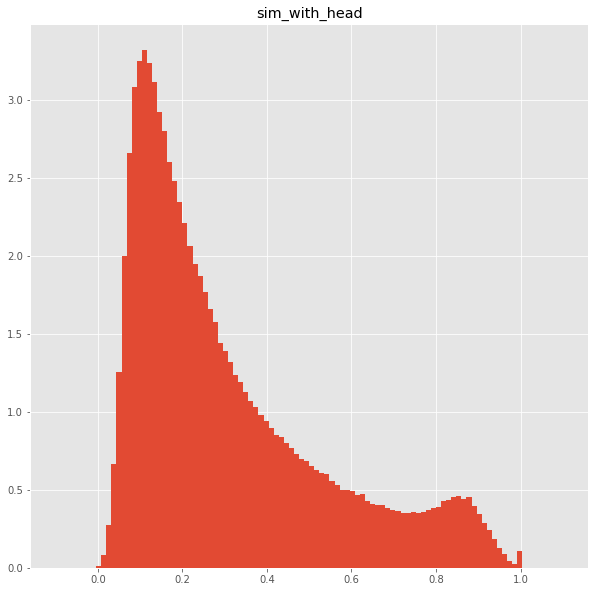

In [53]:
_=compound_head_sim.hist(column ='sim_with_head', figsize=(10, 10),bins=100,sharex=True,sharey=True,normed=True,range=(-0.1,1.1))

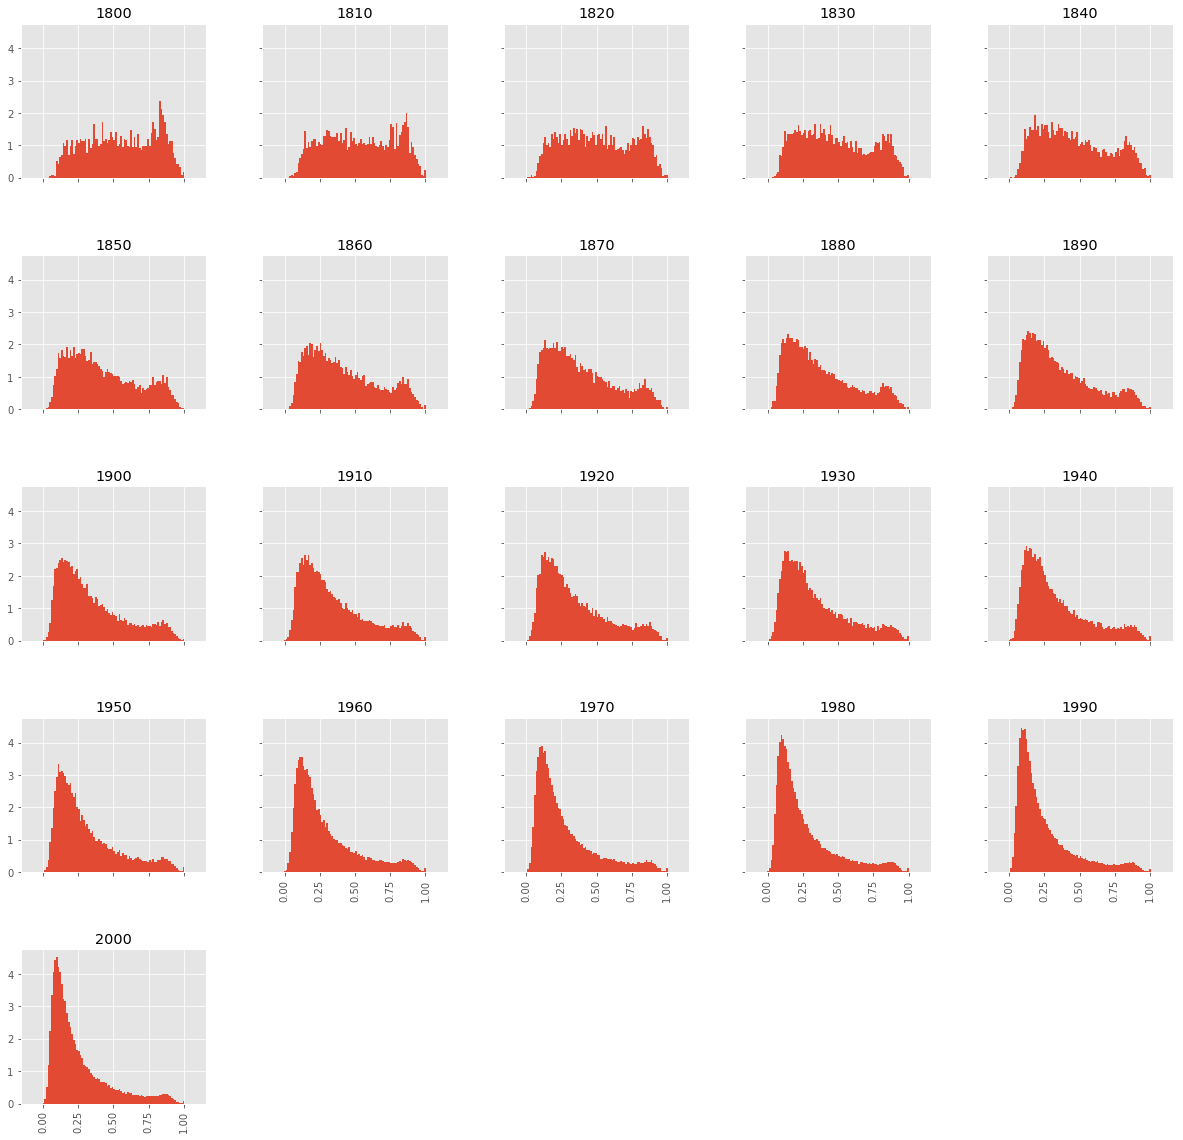

In [54]:
_=compound_head_sim.hist(by= 'decade',column ='sim_with_head', figsize=(20, 20),bins=100,sharex=True,sharey=True,normed=True,range=(-0.1,1.1))

## Similarity between Modifier and Head

In [55]:
constituent_sim=pd.merge(new_heads.reset_index(),new_compounds.reset_index(),on=["head","context","decade"])
constituent_sim=pd.merge(constituent_sim,new_modifiers.reset_index(),on=["modifier","context","decade"])
constituent_sim['numerator']=constituent_sim['head_ppmi']*constituent_sim['modifier_ppmi']
constituent_sim=constituent_sim.groupby(['modifier','head','decade'])['numerator'].sum().to_frame()
constituent_sim=pd.merge(constituent_sim.reset_index(),head_denom.reset_index(),on=["head","decade"])
constituent_sim=pd.merge(constituent_sim,modifier_denom.reset_index(),on=["modifier","decade"])
constituent_sim['sim_bw_constituents']=constituent_sim['numerator']/(constituent_sim['head_denom']*constituent_sim['modifier_denom'])
constituent_sim.set_index(['modifier','head','decade'],inplace=True)
constituent_sim.drop(['numerator','modifier_denom','head_denom'],axis=1,inplace=True)
constituent_sim

sim_bw_constituents
modifier     head          decade                     
a_n          bell_n        1970                  0.038
             chorus_n      1970                  0.236
             star_n        1970                  0.041
             streetcar_n   1970                  0.455
alarm_n      bell_n        1970                  0.135
             service_n     1970                  0.010
             system_n      1970                  0.048
             rate_n        1970                  0.051
             barking_n     1970                  0.079
             clock_n       1970                  0.080
             gun_n         1970                  0.053
brass_n      bell_n        1970                  0.061
             band_n        1970                  0.010
             plate_n       1970                  0.114
             ball_n        1970                  0.033
             instrument_n  1970                  0.051
             aluminum_n    1970                  0.320
             button_n      1970                  0.066
             copper_n      1970                  0.193
             rail_n        1970                  0.055
             tongue_n      1970                  0.078
canterbury_n bell_n        1970                  0.024
             pilgrim_n     1970                  0.028
             cathedral_n   1970                  0.264
             tale_n        1970                  0.176
chapel_n     bell_n        1970                  0.027
             today_n       1970                  0.009
             history_n     1970                  0.078
             royal_n       1970                  0.013
charles_n    bell_n        1970                  0.009
...                                                ...
woman_n      poison_n      1800                  0.268
             report_n      1800                  0.297
             seeker_n      1800                  0.318
woodland_n   flower_n      1830                  0.518
wool_n       realization_n 1930                  0.587
worm_n       infestation_n 1970                  0.373
writer_n     ridicule_n    1800                  0.293
                           1810                  0.302
writing_n    train_n       1810                  0.463
wyoming_n    territory_n   1870                  0.391
x_n          breadth_n     1880                  0.818
xerox_n      software_n    1870                  0.470
                           1880                  0.473
                           1890                  0.471
                           1900                  0.474
                           1910                  0.479
                           1920                  0.478
                           1930                  0.477
                           1940                  0.420
                           1950                  0.437
xxxiv_n      referendum_n  1980                  0.452
yam_n        vine_n        1920                  0.084
                           1960                  0.074
yankee_n     league_n      1840                  0.423
yesterday_n  morning_n     1800                  0.386
yew_n        bough_n       1810                  0.602
                           1830                  0.599
                           1840                  0.602
                           1850                  0.599
young_n      lady_n        1800                  0.347

[456680 rows x 1 columns]

In [56]:
constituent_sim.describe()

,sim_bw_constituents
count,456680.000
mean,0.082
std,0.104
min,0.000
25%,0.020
50%,0.045
75%,0.100
max,1.000


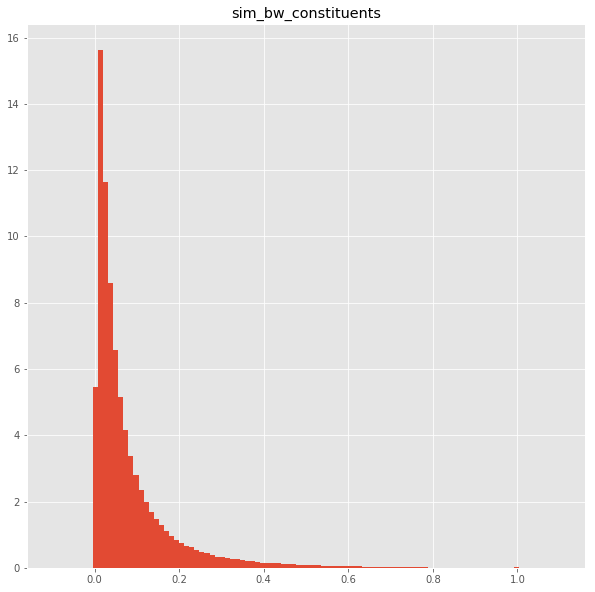

In [57]:
_=constituent_sim.hist(column ='sim_bw_constituents', figsize=(10, 10),bins=100,sharex=True,sharey=True,normed=True,range=(-0.1,1.1))

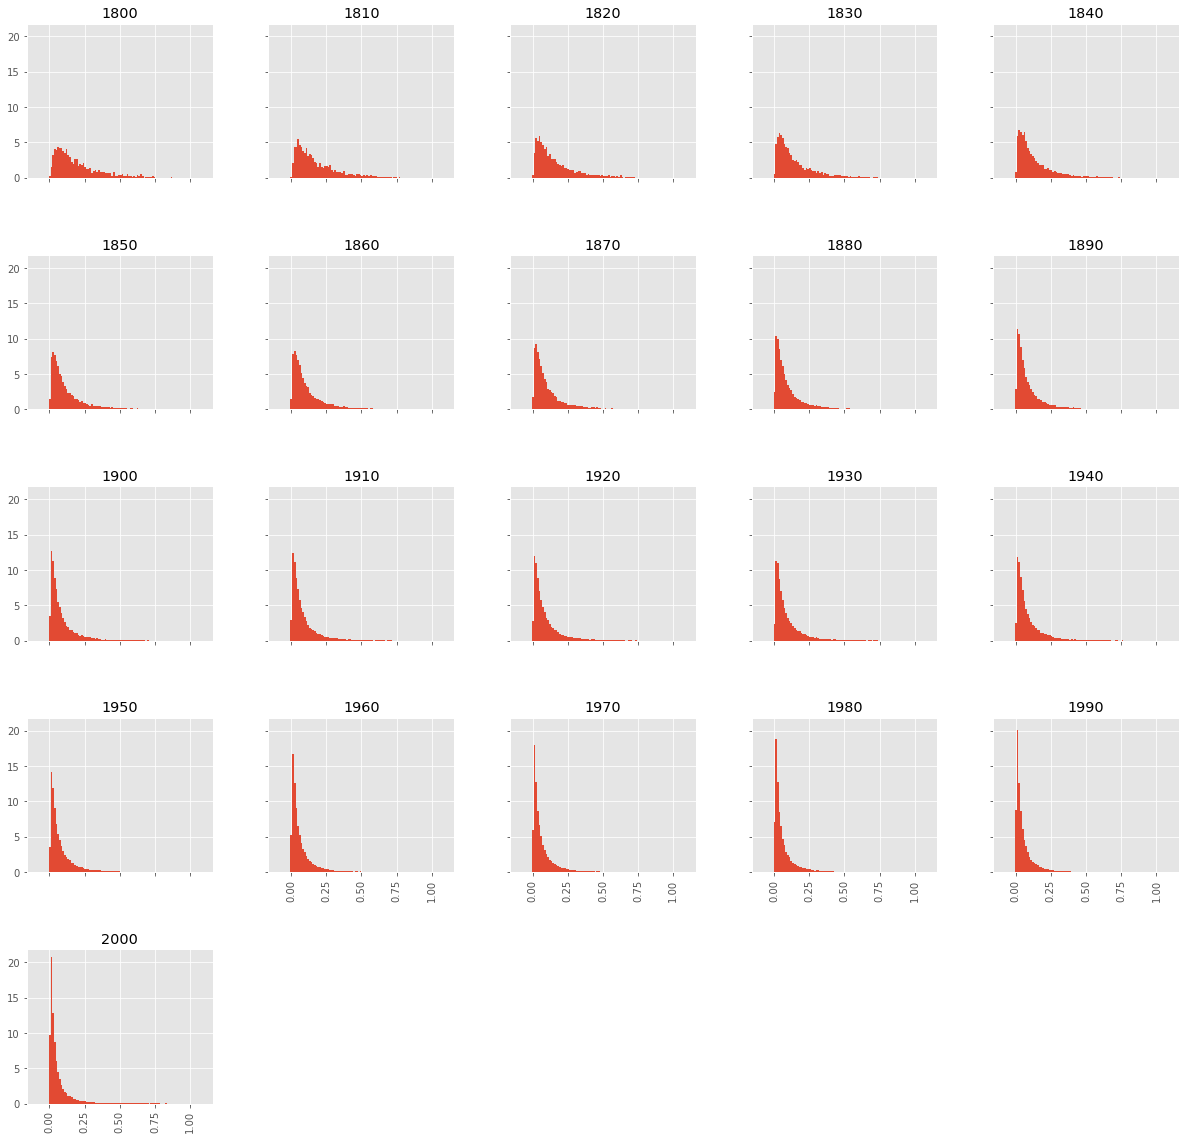

In [58]:
_=constituent_sim.hist(by= 'decade',column ='sim_bw_constituents', figsize=(20, 20),bins=100,sharex=True,sharey=True,normed=True,range=(-0.1,1.1))

## Regression Tests

In [59]:
dfs = [constituent_sim.reset_index(), compound_head_sim.reset_index(), compound_modifier_sim.reset_index(), information_feat.reset_index()]
compounds_final = reduce(lambda left,right: pd.merge(left,right,on=['modifier','head','decade']), dfs)
compounds_final.drop(['head_denom','modifier_denom'],axis=1,inplace=True)
compounds_final=pd.pivot_table(compounds_final, index=['modifier','head'], columns=['decade'])
compounds_final.fillna(0,inplace=True)
compounds_final -= compounds_final.min()
compounds_final /= compounds_final.max()
compounds_final_1=compounds_final.columns.get_level_values(0)
compounds_final_2=compounds_final.columns.get_level_values(1)

cur_year=0
new_columns=[]
for year in compounds_final_2:
    new_columns.append(str(year)+"_"+compounds_final_1[cur_year])
    cur_year+=1
compounds_final.columns=new_columns
compounds_final

1800_local_mi  1810_local_mi  1820_local_mi  \
modifier     head                                                         
a_n          bell_n                 0.000          0.001          0.002   
             c_n                    0.021          0.010          0.002   
             cassell_n              0.000          0.001          0.002   
             chorus_n               0.000          0.001          0.002   
             colonial_n             0.000          0.001          0.002   
             man_n                  0.000          0.001          0.002   
             publisher_n            0.000          0.001          0.002   
             sand_n                 0.000          0.001          0.002   
             series_n               0.000          0.001          0.002   
             star_n                 0.000          0.001          0.002   
             streetcar_n            0.000          0.001          0.002   
             y_n                    0.000          0.001          0.002   
aa_n         group_n                0.000          0.001          0.002   
             name_n                 0.000          0.001          0.002   
aaa_n        study_n                0.000          0.001          0.002   
aaron_n      burr_n                 0.000          0.008          0.002   
             douglas_n              0.000          0.001          0.002   
             presley_n              0.000          0.001          0.002   
             smith_n                0.000          0.001          0.002   
             spark_n                0.000          0.001          0.002   
             stark_n                0.000          0.001          0.002   
ab_n         blood_n                0.000          0.001          0.002   
             cd_n                   0.000          0.001          0.002   
             people_n               0.000          0.001          0.002   
             performance_n          0.000          0.001          0.002   
             tract_n                0.000          0.001          0.002   
aba_n        advisory_n             0.000          0.001          0.002   
             antitrust_n            0.000          0.001          0.002   
             canon_n                0.000          0.001          0.002   
             model_n                0.000          0.001          0.002   
...                                   ...            ...            ...   
zipper_n     bag_n                  0.000          0.001          0.002   
zone_n       academy_n              0.000          0.001          0.002   
             act_n                  0.000          0.001          0.002   
             b_n                    0.000          0.001          0.002   
             color_n                0.000          0.001          0.002   
             commander_n            0.000          0.001          0.002   
             concept_n              0.000          0.001          0.002   
             criterion_n            0.000          0.001          0.002   
             d_n                    0.000          0.001          0.002   
             government_n           0.000          0.001          0.002   
             ii_n                   0.000          0.001          0.002   
             lymphoma_n             0.000          0.001          0.002   
             management_n           0.000          0.001          0.002   
             product_n              0.000          0.001          0.002   
             size_n                 0.000          0.001          0.002   
             temperature_n          0.000          0.001          0.002   
             treaty_n               0.000          0.001          0.002   
zoning_n     authority_n            0.000          0.001          0.002   
             commission_n           0.000          0.001          0.002   
             interest_n             0.000          0.001          0.002   
             law_n                  0.000          0.

In [61]:
compounds_final.reset_index()

(78105, 126)

## Graves et. al 2013

In [50]:
graves13_study=pd.read_excel("13428_2012_256_MOESM1_ESM.xlsx",usecols=[0,1,2,3])
graves13_study['modifier'],graves13_study['head']=graves13_study['Stim'].str.split('-', 1).str
graves13_study['modifier']=np.vectorize(lemma_maker)(graves13_study['modifier'])
graves13_study['head']=np.vectorize(lemma_maker)(graves13_study['head'])
graves13_study.replace(replacements,inplace=True)
graves13_study['modifier']=graves13_study['modifier']+"_n"
graves13_study['head']=graves13_study['head']+"_n"
graves13_study.drop(["Stim"],axis=1,inplace=True)
graves13_study.set_index(['modifier','head'],inplace=True)
graves13_study

Class  Mean_rate    SD
modifier   head                                  
bus_n      bridge_n     Positive      1.345 1.396
           window_n     Positive      3.828 0.539
           home_n       Positive      1.828 1.605
bike_n     pant_n       Positive      2.897 1.472
           barn_n       Positive      1.429 1.425
           leg_n        Positive      1.138 1.356
           home_n       Positive      1.483 1.595
           headlight_n  Positive      3.448 0.985
           seat_n       Positive      3.793 0.774
police_n   dog_n        Positive      4.000 0.000
           star_n       Positive      2.034 1.742
           car_n        Positive      4.000 0.000
           horse_n      Positive      3.690 0.806
           truck_n      Positive      3.724 0.528
           telephone_n  Positive      3.241 1.215
           radio_n      Positive      3.724 0.922
           bomb_n       Positive      2.586 1.500
           vehicle_n    Positive      4.000 0.000
           tape_n       Positive      3.655 0.974
           van_n        Positive      3.862 0.581
cab_n      car_n        Positive      2.966 1.295
           truck_n      Positive      1.345 1.203
           window_n     Positive      3.793 0.559
           home_n       Positive      1.724 1.533
sled_n     dog_n        Positive      3.552 0.948
chimp_n    mother_n     Positive      3.103 1.175
beach_n    sunset_n     Positive      3.310 1.228
           ball_n       Positive      4.000 0.000
           house_n      Positive      3.862 0.441
           sand_n       Positive      3.250 1.206
...                          ...        ...   ...
cave_n     mountain_n   Negative      1.786 1.287
winter_n   mountain_n   Negative      2.214 1.397
golf_n     mountain_n   Negative      1.107 1.166
lake_n     mountain_n   Negative      1.071 1.184
goat_n     mountain_n   Negative      1.786 1.475
road_n     mountain_n   Negative      0.857 1.113
meadow_n   mountain_n   Negative      1.286 1.243
building_n mountain_n   Negative      0.357 0.621
face_n     mountain_n   Negative      0.429 0.742
ear_n      elephant_n   Negative      0.786 0.876
boot_n     car_n        Negative      0.714 0.976
nut_n      car_n        Negative      0.714 1.084
window_n   car_n        Negative      1.071 0.900
home_n     car_n        Negative      1.536 1.427
radio_n    car_n        Negative      1.107 0.956
body_n     car_n        Negative      1.107 1.227
phone_n    car_n        Negative      0.964 1.401
bomb_n     car_n        Negative      1.500 1.552
magazine_n car_n        Negative      0.607 0.786
building_n car_n        Negative      0.786 1.067
plant_n    car_n        Negative      0.333 0.877
seat_n     car_n        Negative      1.214 1.343
engine_n   car_n        Negative      1.286 1.301
bed_n      stream_n     Negative      0.571 1.034
           ocean_n      Negative      0.786 1.031
water_n    ocean_n      Negative      1.179 1.156
swimming_n ocean_n      Negative      1.643 1.193
surf_n     ocean_n      Negative      1.000 0.943
house_n    milk_n       Negative      1.357 1.224
coffee_n   milk_n       Negative      2.036 1.374

[2160 rows x 3 columns]

In [51]:
compounds_final_graves=pd.merge(graves13_study.reset_index(),compounds_final.reset_index(),on=['modifier','head'])
#compounds_final.set_index(['modifier','head'],inplace=True)
compounds_final_graves.set_index(['modifier','head'],inplace=True)
compounds_final_graves

Class  Mean_rate    SD  1800_local_mi  \
modifier     head                                                   
police_n     car_n       Positive      4.000 0.000          0.000   
             tape_n      Positive      3.655 0.974          0.000   
cab_n        home_n      Positive      1.724 1.533          0.000   
beach_n      sand_n      Positive      3.250 1.206          0.000   
television_n picture_n   Positive      3.690 0.712          0.000   
field_n      kitchen_n   Positive      0.793 1.177          0.000   
             hospital_n  Positive      2.138 1.663          0.000   
             mouse_n     Positive      3.621 1.147          0.000   
             army_n      Positive      2.690 1.285          0.000   
dog_n        book_n      Positive      2.517 1.661          0.000   
water_n      tower_n     Positive      4.000 0.000          0.000   
             pipe_n      Positive      3.724 0.882          0.000   
pant_n       leg_n       Positive      2.828 1.513          0.000   
cigarette_n  butt_n      Positive      3.724 0.882          0.000   
             smoke_n     Positive      3.931 0.371          0.000   
             money_n     Positive      3.034 1.426          0.000   
fire_n       ant_n       Positive      3.483 1.184          0.000   
             bell_n      Positive      3.069 1.334          0.000   
             truck_n     Positive      3.862 0.743          0.000   
             engine_n    Positive      3.793 0.620          0.000   
automobile_n engine_n    Positive      4.000 0.000          0.000   
star_n       field_n     Positive      1.310 1.514          0.000   
blood_n      stream_n    Positive      3.517 1.153          0.000   
             sugar_n     Positive      3.429 1.345          0.000   
             alcohol_n   Positive      3.034 1.451          0.000   
             money_n     Positive      2.276 1.601          0.000   
mountain_n   bike_n      Positive      4.000 0.000          0.000   
             stream_n    Positive      3.483 1.090          0.000   
             lion_n      Positive      3.828 0.658          0.000   
             forest_n    Positive      3.103 1.291          0.000   
...                           ...        ...   ...            ...   
school_n     building_n  Positive      3.963 0.192          0.000   
             book_n      Positive      3.857 0.591          0.000   
grass_n      house_n     Positive      2.321 1.416          0.000   
picture_n    book_n      Positive      3.929 0.262          0.000   
crown_n      jewel_n     Positive      3.321 0.983          0.015   
             prince_n    Positive      2.667 1.544          0.000   
coffin_n     lid_n       Positive      3.750 0.701          0.000   
cabin_n      boy_n       Positive      3.111 1.251          0.000   
             window_n    Positive      3.929 0.262          0.000   
             door_n      Positive      3.964 0.189          0.000   
street_n     car_n       Positive      3.857 0.448          0.000   
rib_n        cage_n      Positive      3.893 0.567          0.000   
pendulum_n   clock_n     Positive      3.714 0.713          0.000   
bible_n      school_n    Positive      3.821 0.390          0.000   
army_n       hospital_n  Positive      3.714 0.713          0.000   
witch_n      doctor_n    Positive      3.679 0.772          0.000   
trash_n      bag_n       Positive      4.000 0.000          0.000   
sleigh_n     bell_n      Positive      3.857 0.756          0.000   
gold_n       leaf_n      Positive      3.630 0.926          0.000   
bubble_n     gum_n       Positive      4.000 0.000          0.000   
plant_n      water_n     Positive      2.429 1.526          0.000   
chestnut_n   tree_n      Positive      3.964 0.189          0.000   
face_n       mask_n      Positive      3.889 0.320          0.000   
brick_n      building_n  Positive      4.000 0.000          0.009   
shepherd_n   boy_n       Positive      3.679 0.819          0.000   
sand_n       beach_n     N

## Reddy et. al 2013

In [52]:
reddy11_study=pd.read_csv("ijcnlp_compositionality_data/MeanAndDeviations.clean.txt",sep="\t")
#print(reddy11_study.columns)
reddy11_study.columns=['compund','to_divide']
reddy11_study['modifier_mean'],reddy11_study['modifier_std'],reddy11_study['head_mean'],reddy11_study['head_std'],reddy11_study['compound_mean'],reddy11_study['compound_std'],_=reddy11_study.to_divide.str.split(" ",7).str
reddy11_study['modifier'],reddy11_study['head']=reddy11_study['compund'].str.split(" ",2).str
reddy11_study.modifier=reddy11_study.modifier.str[:-2]
reddy11_study['head']=reddy11_study['head'].str[:-2]
reddy11_study.drop(['compund','to_divide'],axis=1,inplace=True)
reddy11_study['modifier']=np.vectorize(lemma_maker)(reddy11_study['modifier'])
reddy11_study['head']=np.vectorize(lemma_maker)(reddy11_study['head'])
reddy11_study.replace(replacements,inplace=True)
reddy11_study['modifier']=reddy11_study['modifier']+"_n"
reddy11_study['head']=reddy11_study['head']+"_n"
reddy11_study

,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,modifier,head
0,3.866667,1.117537,4.866667,0.339935,4.250000,0.871165,end_n,user_n
1,1.607143,1.654848,1.892857,1.496169,1.703704,1.717337,firing_n,line_n
2,2.821429,1.964935,4.862069,0.344828,3.827586,1.233693,game_n,plan_n
3,4.766667,0.422953,4.862069,0.344828,4.800000,0.476095,application_n,form_n
4,0.600000,0.800000,4.586207,1.099129,1.310345,1.020596,snail_n,mail_n
5,2.678571,1.691440,3.933333,1.181336,3.785714,1.205853,web_n,site_n
6,0.379310,0.805746,4.714286,0.839096,1.517241,1.133219,flea_n,market_n
7,0.428571,0.775913,5.000000,0.000000,2.642857,1.315139,grandfather_n,clock_n
8,1.066667,1.289272,3.407407,1.340516,1.703704,1.047566,diamond_n,wedding_n
9,4.714286,0.589015,0.862069,0.936764,2.185185,1.155888,guilt_n,trip_n


In [53]:
compounds_final_reddy=pd.merge(reddy11_study,compounds_final.reset_index(),on=['modifier','head'])
compounds_final_reddy.set_index(['modifier','head'],inplace=True)
compounds_final_reddy

,,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,1800_local_mi,1810_local_mi,1820_local_mi,1830_local_mi,...,1910_sim_with_modifier,1920_sim_with_modifier,1930_sim_with_modifier,1940_sim_with_modifier,1950_sim_with_modifier,1960_sim_with_modifier,1970_sim_with_modifier,1980_sim_with_modifier,1990_sim_with_modifier,2000_sim_with_modifier
modifier,head,,,,,,,,,,,,,,,,,,,,,
end_n,user_n,3.866667,1.117537,4.866667,0.339935,4.250000,0.871165,0.000,0.001,0.002,0.002,...,0.000,0.000,0.000,0.000,0.000,0.000,0.173,0.174,0.174,0.145
firing_n,line_n,1.607143,1.654848,1.892857,1.496169,1.703704,1.717337,0.000,0.001,0.002,0.002,...,0.000,0.565,0.578,0.488,0.631,0.611,0.640,0.499,0.370,0.390
application_n,form_n,4.766667,0.422953,4.862069,0.344828,4.800000,0.476095,0.000,0.001,0.002,0.002,...,0.260,0.230,0.176,0.245,0.265,0.301,0.231,0.268,0.219,0.223
web_n,site_n,2.678571,1.691440,3.933333,1.181336,3.785714,1.205853,0.000,0.001,0.002,0.002,...,0.000,0.000,0.000,0.000,0.000,0.267,0.391,0.526,0.671,0.647
silver_n,spoon_n,1.592593,1.472193,1.444444,1.770820,1.518519,1.449658,0.000,0.001,0.002,0.002,...,0.000,0.000,0.000,0.000,0.000,0.000,0.083,0.103,0.084,0.083
rush_n,hour_n,3.107143,1.371633,2.862069,1.357588,3.333333,1.273665,0.000,0.001,0.002,0.002,...,0.000,0.000,0.000,0.000,0.000,0.000,0.765,0.759,0.758,0.762
mailing_n,list_n,4.666667,0.537484,4.933333,0.249444,4.666667,0.471405,0.000,0.001,0.002,0.002,...,0.000,0.000,0.000,0.271,0.000,0.220,0.185,0.208,0.576,0.435
spelling_n,bee_n,4.814815,0.771580,0.517241,1.037925,2.448276,1.248066,0.000,0.001,0.002,0.002,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.276
public_n,service_n,4.666667,0.649786,4.766667,0.615540,4.400000,0.757188,0.000,0.001,0.002,0.002,...,0.147,0.191,0.217,0.150,0.098,0.151,0.202,0.269,0.265,0.215


In [56]:
with open('compounds_final_graves.csv', 'w') as f1:
    compounds_final_graves.to_csv(f1, header=True,sep="\t")

In [57]:
with open('compounds_final_reddy.csv', 'w') as f1:
    compounds_final_reddy.to_csv(f1, header=True,sep="\t")

In [ ]:
compounds_decade_counts=compounds.decade.value_counts().to_frame()
compounds_decade_counts.columns=["Count"]
compounds_decade_counts['Perc']=round((compounds_decade_counts.Count/compounds_decade_counts.Count.sum())*100,3)
display(compounds_decade_counts)

In [ ]:
compounds_decade_counts.drop('Count',axis=1).plot.bar()

In [ ]:
compounds_list=list(set(zip(compounds.modifier,compounds['head'])))
len(compounds_list)